<a href="https://colab.research.google.com/github/Mario-uni/DAIProLi/blob/main/DAIProLi_6_esp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Determinación de Afinidad de Interacción entre Proteína y Ligando



In [3]:
#@title Librerias y funciones
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd

from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.models import Legend


from scipy.optimize import curve_fit, leastsq, least_squares
from google.colab import files
from google.colab import drive
import os

# Esto es temporal, la solución final sería subir el modulo al github de Unizar
!git clone https://github.com/Mario-uni/DAIProLi.git
from DAIProLi.funcionesGenerales import leeFichero, preprocesaAbsorbance, procesa, argLeastSquares

##Funciones específicas

def leeFichero(nombrFich, colValLabel='Wavelength nm.', intercaladas=True, separador=','):
  # Abrimos el fichero
  with open(nombrFich,'r') as fichero:
    # Inicializamos las variables
    col_names = []
    data_rows = []
    #row_names = []

    # Iteramos por las lineas del fichero
    for linea in fichero:
      row = []

      # Si esta línea es la linea que contiene la colValLabel, extraemos los nombres/valores de las columna
      if linea.split(separador)[0] == colValLabel:
        col_names = [dato.strip() for dato in linea.split(separador) if dato.strip()]
      else:
          # Procesamos cada fila de datos
          values=[dato.strip() for dato in linea.split(separador) if dato.strip()]

          if values:
            #row_name = values[0] # El primer valor es el nombre de la fila (Wavelength)
            row_values = values # El resto de los valores lo ponemos como datos

            # Si intercaladas es cierto, tomamos los valores en posiiones pares de row_values
            if intercaladas:
              row_values=row_values[::2]

            # Intentamos convertir cada valor en float, pero nos quedamos con string si no es possible
            processed_row=[]
            for dato in row_values:
              try:
                processed_row.append(float(dato)) # Intentamos convertir en float
              except ValueError:
                processed_row.append(dato) # Nos quedamos el string si no es in float

            #row_names.append(row_name) # Recogemos los nombres de las filas
            data_rows.append(processed_row) # Recogemos los datos de las filas

  # Creamos un DataFrame para los datos recogidos
  df = pd.DataFrame(data_rows)

  # Ponemos los col_names como nombres de las columna, asegurandonos que su numero coincide con el
  # número de columnas en los datos.
  if len(col_names)== len(df.columns) :
    df.columns = col_names # Nos saltamos la primera etiqueta (que es para los nombre de las filas) REVISAR
  else:
    print(f"Warning: The number of columns in the data does not match the header size")
  return df


def preprocesaAbsorbance(df):
  #df=datos
  # Extraemos los valores de la primera columna (Wavelength nm.)
  wavelength= df.iloc[:,0] # La primer columna contiene los valores de longitud de onda

  # Extramemos las medidas de absorbancia (todas las columnas menos la primera)
  absorbance= df.iloc[:,1:]

  # Extraemos los nombres de las columnas a partir de la tercera (incluida)
  volume= df.columns[2:]
  volume = pd.to_numeric(volume)

  # Inicializamos las listas para almacenar los mínimos, máximos y sus respectivas longitudes de onda
  min_vals = []
  max_vals = []
  min_wave = []
  max_wave = []

  # Iteramos sobre cada columna (excepto la primera y la segunda, longitud de onda y baseline respectivamente)
  for col in df.columns[2:]:
    # Encontramos el valor mínimo, máximo y su correspondiente longitud de onda
      min_val = df[col].min()
      max_val = df[col].max()

      min_wl = df[df[col] == min_val]['Wavelength nm.'].iloc[0]
      max_wl = df[df[col] == max_val]['Wavelength nm.'].iloc[0]

      # Almacenamos en las listas
      min_vals.append(min_val)
      max_vals.append(max_val)
      min_wave.append(min_wl)
      max_wave.append(max_wl)


  #Calculamos el primedio de las longitudes de onda correpondientes a los mínimos y máximos
  avg_min_wave = np.mean(min_wave)
  avg_max_wave = np.mean(max_wave)

  # Redondeamos las longitudes al incremente más cercano de 0.5 nm
  avg_min_wave = round(avg_min_wave *2)/2 # Asegurando incrementos de 0.5 nm
  avg_max_wave = round(avg_max_wave *2)/2



  # Encontramos las filas en el DataFrame que corresponden a las longitudes de onda redondeadas
  min_abs = df[df['Wavelength nm.'] == avg_min_wave].iloc[:,2:].reset_index(drop=True).T
  max_abs = df[df['Wavelength nm.'] == avg_max_wave].iloc[:,2:].reset_index(drop=True).T

  # Calculamos deltaAbs como la diferencia entre los absorbancias en las longitudes de onda redondeadas
  deltaAbs = max_abs - min_abs

  # Creamos un DataFrame de salida con los resultados
  out_df = deltaAbs
  out_df.insert(0, column ='',value=volume)
  out_df.reset_index(drop=True, inplace=True)
  out_df.columns= ['Volume ul', 'DeltaAbs']


  # Imprimimos los valores calculados
  print(f'Mínimo promedio:  ({avg_min_wave} nm)\t Máximo promedio:  ({avg_max_wave} nm)')
  print(f'  {out_df}\n')

  return out_df


########

# Definir la función de ajuste basada en el modelo matemático
def binding_model (params, v):
    # Combinamos ambos diccionarios (params)
    # params={**fixed_params, **variable_params}

    # Extraemos los parametros del dicionario combinado
    L = params['L']
    V0 = params['V0']
    Lo = params['Lo']
    Ro = params['Ro']
    Kd = params['Kd']
    epsilon = params['epsilon']

    Lt = Lo * v / (V0 + v)
    Rt = Ro * V0 / (V0 + v)
    deltaAbs = epsilon * L * (Lt + Rt + Kd - np.sqrt((Lt + Rt + Kd)**2 - 4 * Lt * Rt)) / 2
    return deltaAbs



fatal: destination path 'DAIProLi' already exists and is not an empty directory.


In [4]:
#@title Subir archivo, formato csv y preprocesaAbsorbance

# Subir el archivo y guardarlo en un diccionario
uploaded=files.upload()

# Obtener el nombre del arcivo subido al diccionario
file_name=list(uploaded.keys())[0]
# @markdown **Columnas intercaladas**

Intercaladas = False #@param {type:"boolean"}

# @markdown **Separador columnas**
Separador = "," #@param [",", ";"]
datos= leeFichero(nombrFich=file_name, intercaladas= Intercaladas, separador=Separador)
print(datos)

print("PreprocesaAbsorbance:")

DeltaAbs= preprocesaAbsorbance(datos)


Saving Kd_ORD1_t.csv to Kd_ORD1_t.csv
     Wavelength nm.  Baseline       2       4       6       8      10      12  \
0             300.0   -0.0002  0.0004  0.0031  0.0034  0.0030  0.0022  0.0058   
1             300.5   -0.0001  0.0004  0.0029  0.0034  0.0028  0.0021  0.0056   
2             301.0   -0.0001  0.0004  0.0027  0.0032  0.0027  0.0016  0.0053   
3             301.5   -0.0002  0.0002  0.0027  0.0028  0.0024  0.0014  0.0048   
4             302.0   -0.0003  0.0002  0.0025  0.0026  0.0022  0.0012  0.0045   
..              ...       ...     ...     ...     ...     ...     ...     ...   
596           598.0   -0.0002  0.0015  0.0015  0.0015  0.0014  0.0015  0.0023   
597           598.5   -0.0002  0.0014  0.0015  0.0015  0.0014  0.0014  0.0022   
598           599.0   -0.0002  0.0014  0.0015  0.0015  0.0014  0.0014  0.0022   
599           599.5   -0.0002  0.0014  0.0014  0.0015  0.0013  0.0014  0.0021   
600           600.0   -0.0002  0.0014  0.0014  0.0014  0.0013  0.0014  

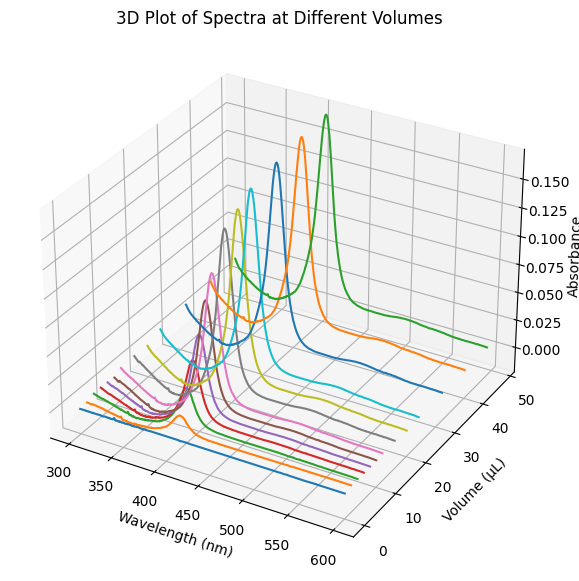

In [5]:
#@title Gráfico espectros
# @markdown En los espacios a continuación
# @markdown puedes escribir los títulos, ejes
# @markdown y titulo de leyenda del gráfico.
from bokeh.palettes import linear_palette, Viridis256
from bokeh.palettes import Category20

### Título del gráfico
Titulo = "Espectros a Diferentes Volúmenes de ***"  #@param {type:"string"}

### Título eje x
y_axis = "Absorbancia" #@param{type:"string"}

### Título eje y
x_axis = "Longitud de onda (nm)" #@param{type:"string"}

### Título leyenda
Leyenda = "Volumen (µL)" #@param{type:"string"}


#@markdown **Eje x**

# Output the plot directly in the notebook
output_notebook()

# Creamos una figura
p = figure(title=Titulo,
           x_axis_label=x_axis,
           y_axis_label=y_axis,
           width=1200, height=700)

# Definimos los tamaños de fuente para el titulo, los ejes y las etiquetas
p.title.text_font_size = '20pt'
p.xaxis.axis_label_text_font_size = '16pt'
p.yaxis.axis_label_text_font_size = '16pt'
p.xaxis.major_label_text_font_size = '12pt'
p.yaxis.major_label_text_font_size = '12pt'




# Generamos una paleta de color personalizada usando Viridis256, con tantos colores como columna de datos haya
n_lines= len(datos.columns[1:])
colors=linear_palette(Viridis256, n_lines)
#colors = Category20[max(3, min(20, n_lines))]  # Category20 supports up to 20 distinct colors


# Iteramos sobre las columnas (cada una representa un volumen differente)
for idx, col in enumerate(datos.columns[1:]):
    p.line(datos.iloc[:, 0], datos[col], legend_label=f'{col}', line_width=2, color=colors[idx])

# Personalizamos la leyenda
p.legend.title = Leyenda
p.legend.location = "top_right"
p.legend.click_policy = "hide"  # Permite ocultar lineas haciendo click en la leyenda
p.toolbar_location = "below"
# Definimos los tamaños de fuente para la leyenda
p.legend.label_text_font_size = '12pt'
p.legend.title_text_font_size = '14pt'
# Mostramos el plot
show(p)


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd

# Simulated data, replace with your actual dataset
wavelengths = datos.iloc[:, 0].values  # Wavelength (nm)

# Assign "Baseline" to 0 and convert the rest to integers
volumes = np.array([0 if col == 'Baseline' else int(col) for col in datos.columns[1:]])  # Volumes (µL)

# Absorbance for each volume (including Baseline)
absorbance = datos.iloc[:, 1:].values

# Create a figure
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot each volume spectrum as a 3D line
for i, vol in enumerate(volumes):
    ax.plot(wavelengths, [vol] * len(wavelengths), absorbance[:, i], label=f'{vol} µL')

# Labels and title
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Volume (µL)')
ax.set_zlabel('Absorbance')
ax.set_title('3D Plot of Spectra at Different Volumes')

# Show the plot
plt.show()

In [6]:
#@title Gráfico Δ Absorbancia vs Volumen (µL)
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource, Legend

### Título del gráfico
Titulo = "Δ Absorbancia en función del volumen añadido ***"  #@param {type:"string"}

### Título eje x
y_axis = "Δ Absorbancia" #@param{type:"string"}

### Título eje y
x_axis = "Volumen (µL)" #@param{type:"string"}

### Título leyenda
Leyenda = "Δ Absorbancia" #@param{type:"string"}


# Display Bokeh plots in the notebook
output_notebook()

# Creamos una figura
p = figure(width=1200, height=700, title=Titulo)

# Añadimos un diagrama de dispersión de puntos
scatter = p.scatter(x=DeltaAbs.iloc[:, 0],y=DeltaAbs.iloc[:, 1] ,  legend_label=Leyenda, color='blue', size=10)

# Personalizamos los títulos de los ejes
p.xaxis.axis_label = x_axis
p.yaxis.axis_label = y_axis



# Definimos los tamaños de fuente para el titulo, los ejes y las etiquetas
p.title.text_font_size = '20pt'
p.xaxis.axis_label_text_font_size = '16pt'
p.yaxis.axis_label_text_font_size = '16pt'
p.xaxis.major_label_text_font_size = '12pt'
p.yaxis.major_label_text_font_size = '12pt'

# Añadimos la leyenda
p.legend.title = 'Legend'
# Definimos los tamaños de fuente para la leyenda
p.legend.label_text_font_size = '12pt'
p.legend.title_text_font_size = '14pt'
p.legend.location = "bottom_right"
p.toolbar_location = "below"
# Mostramos el gráfico
show(p)


In [7]:
# @title Parámetros
# @markdown **Parámetros fijos y a optimizar**
# @markdown Selecciona los parametros fijos y aquellos a optimizar:

import numpy as np
# @markdown

# @markdown **- L [cm] (longitud trayectoria luz)**
# Usamos un desplegable para elergir si los parametros deben ser fijados o optimizados
L_fixed = "Yes"  # @param ["Yes", "No"]
L = 1  # @param {type:"number"}

# @markdown

# @markdown **- V0 [µL] (volumen solución inicial)**
V0_fixed = "Yes"  # @param ["Yes", "No"]
V0 = 1000  # @param {type:"number"}

# @markdown

# @markdown **- L0 [µM] (concentración solución inicial ApoMgb - Ligando)**
Lo_fixed = "Yes"  # @param ["Yes", "No"]
Lo = 55  # @param {type:"number"}

# @markdown

# @markdown **- R0 [µM] (concentración solución inicial Hemoglobina - Receptor)**
Ro_fixed = "No"  # @param ["Yes", "No"]
Ro = 2  # @param {type:"number"}

# @markdown

# @markdown **- Kd**
Kd_fixed = "No"  # @param ["Yes", "No"]
Kd = 0.1  # @param {type:"number"}

# @markdown

# @markdown **- epsilon**
epsilon_fixed = "No"  # @param ["Yes", "No"]
epsilon = 0.1  # @param {type:"number"}

# Inicializamos listas para los parametros fijos y variables (estos últimos a optimizar después)
fixed_params = {}
variable_params = {}

if L_fixed == "Yes":
    fixed_params['L'] = L
else:
    variable_params['L'] = L

if V0_fixed == "Yes":
    fixed_params['V0'] = V0
else:
    variable_params['V0'] = V0

if Lo_fixed == "Yes":
    fixed_params['Lo'] = Lo
else:
    variable_params['Lo'] = Lo

if Ro_fixed == "Yes":
    fixed_params['Ro'] = Ro
else:
    variable_params['Ro'] = Ro

if Kd_fixed == "Yes":
    fixed_params['Kd'] = Kd
else:
    variable_params['Kd'] = Kd

if epsilon_fixed == "Yes":
    fixed_params['epsilon'] = epsilon
else:
    variable_params['epsilon'] = epsilon

# Output de los parametros fijos y variables
print("Fixed Parameters:")
for key, value in fixed_params.items():
    print(f"{key} = {value}")

print("\nVariable Parameters:")
for key, value in variable_params.items():
    print(f"{key} = {value}")


Fixed Parameters:
L = 1
V0 = 1000
Lo = 55

Variable Parameters:
Ro = 2
Kd = 0.1
epsilon = 0.1


In [8]:
#@title Procesa
# Preparamos la lista de los nombres de parametros a optimizar
nombrParVar = list(variable_params.keys())

# Valores independientes (v) y dependientes (Absorbancia)
fKwargs = dict(v = DeltaAbs.iloc[:, 0].values) # Datos de volumen ApoMgb añadido
deltaAbs_exp = DeltaAbs.iloc[:, 1].values #Datos de absorbancia

params= {**fixed_params, **variable_params}
cotaInf = [0 for param in nombrParVar]
cotaSup= [2 if param =='Ro' else np.inf for param in nombrParVar]

sol=procesa(argLeastSquares = argLeastSquares,
                     dictParEstim = params,
                     nombrParVar = nombrParVar,
                     f = binding_model,
                     fKwargs = fKwargs,
                     Y = deltaAbs_exp,
                     bounds =[cotaInf, cotaSup])


	||residuals|| = 0.16851449282209666
	||residuals|| = 0.1685144936859251
	||residuals|| = 0.16851449580792657
	||residuals|| = 0.16851445734199796
	||residuals|| = 0.11875087749403823
	||residuals|| = 0.11875087591820634
	||residuals|| = 0.1187508769469125
	||residuals|| = 0.11875087688612267
	||residuals|| = 0.105055576719204
	||residuals|| = 0.10505557558770505
	||residuals|| = 0.10505557784952405
	||residuals|| = 0.10505556944741476
	||residuals|| = 0.08452576428542997
	||residuals|| = 0.08452576363742273
	||residuals|| = 0.0845257652985484
	||residuals|| = 0.0845257600735381
	||residuals|| = 0.14328090204014213
	||residuals|| = 0.07473946650031653
	||residuals|| = 0.07473946647271754
	||residuals|| = 0.07473946734123657
	||residuals|| = 0.0747394646896605
	||residuals|| = 0.06899799916152762
	||residuals|| = 0.06899799379954183
	||residuals|| = 0.06899800156395984
	||residuals|| = 0.0689979911203632
	||residuals|| = 0.0470639878446351
	||residuals|| = 0.04706398526330407
	||residua

In [9]:
# @title Gráfico Δ Absorbancia vs Volumen (µL) con el ajuste del modelo
from bokeh.plotting import figure, show
from bokeh.io import output_notebook


### Título del gráfico
Titulo = "Δ Absorbancia en función del volumen añadido ***"  #@param {type:"string"}

### Título eje x
y_axis = "Δ Absorbancia" #@param{type:"string"}

### Título eje y
x_axis = "Volumen (µL)" #@param{type:"string"}

### Título leyenda
Leyenda = "Δ Absorbancia" #@param{type:"string"}


# Display Bokeh plots in the notebook
output_notebook()

# Simulación de datos usando los parámetros optimizados
v = DeltaAbs.iloc[:, 0].values
fitted_deltaAbs = binding_model(sol['parAjustados'], v) # Datos de volumen
deltaAbs_exp= DeltaAbs.iloc[:,1].values

# Creamos una figura
p = figure(width=1200, height=700, title=Titulo)

# Añadimos un gráfico de dispersión de puntos (datos experimentales)
scatter = p.scatter(x=v,y=deltaAbs_exp ,  legend_label=Leyenda, color='blue', size=10)

# Añadimos un gráfico de líneas
p.line(x=v, y=fitted_deltaAbs, legend_label='Ajuste del modelo', color='red', line_width=3)

# Definimos los títulos de los ejes
p.xaxis.axis_label = x_axis
p.yaxis.axis_label = y_axis

# Definimos los tamaños de fuente para el titulo, los ejes y las etiquetas
p.title.text_font_size = '20pt'
p.xaxis.axis_label_text_font_size = '16pt'
p.yaxis.axis_label_text_font_size = '16pt'
p.xaxis.major_label_text_font_size = '12pt'
p.yaxis.major_label_text_font_size = '12pt'

# Añadimos la leyenda
p.legend.title = 'Legend'
# Definimos los tamaños de fuente para la leyenda
p.legend.label_text_font_size = '12pt'
p.legend.title_text_font_size = '14pt'
p.legend.location = "bottom_right"
p.toolbar_location = "below"
# Show the plot
show(p)
